# LightGCN for Multimodal Music Recommendation
By Gaurav Anand, Samantha Liu and Yiwei Ou

For the CS224W Fall 2024 Final Project

In [4]:
%%capture
import torch
# Environment Setup (note that capture silences the console output)
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric

In [5]:
# Standard library imports
import random
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
import os
# load listening event data (train, validation, test, and all)
data_dir = os.path.normpath('/content/')
train_data = pd.read_parquet(os.path.join(data_dir, 'm4a_train.parquet'))
val_data = pd.read_parquet(os.path.join(data_dir, 'm4a_val.parquet'))
test_data = pd.read_parquet(os.path.join(data_dir, 'm4a_test.parquet'))
all_data = pd.read_parquet(os.path.join(data_dir, 'm4a_all.parquet'))

# load id maps
user_id_map = pd.read_parquet(os.path.join(data_dir, 'm4a_user_mapping.parquet'))
user_id_map = {user_id: graph_user_id for _, (user_id, graph_user_id) in user_id_map[['user_id', 'graph_user_id']].iterrows()}
track_id_map_data = pd.read_parquet(os.path.join(data_dir, 'm4a_track_mapping.parquet'))
track_id_map = {track_id: graph_track_id for _, (track_id, graph_track_id) in track_id_map_data[['track_id', 'graph_track_id']].iterrows()}
track_id_map2 = {graph_track_id: track_id for _, (track_id, graph_track_id) in track_id_map_data[['track_id', 'graph_track_id']].iterrows()}

# load track features
track_features_df = pd.read_parquet('/content/M4A_song features_with img_Final.parquet')
print(track_features_df.shape)
track_features_df = track_features_df[track_features_df['id'].isin(track_id_map.keys())]
print(track_features_df.shape)
track_features = track_features_df.set_index('id')[
    ['lyrics_embedding', 'danceability', 'energy', 'key', 'popularity', 'valence', 'tempo']
].to_dict(orient='index')

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)
print(all_data.shape)
print(len(user_id_map))
print(len(track_id_map))
print(len(track_features))

(32685, 4975)
(32685, 4975)
(101352, 5)
(21913, 5)
(30196, 6)
(146307, 5)
2312
32685
32685


In [8]:
num_users = len(user_id_map)
num_tracks = len(track_id_map)
print("num_users:", num_users)
print("num_tracks:", num_tracks)

num_users: 2312
num_tracks: 32685


For each epoch during training, we sample the data by generating one negative sample for each positive sample. The requirements for the negative sample are as follows:

1. The negative track has to have been listened to by some user before its corresponding positive track. In reality, this means that the song has been released before the user's listening timestamp. If no such song exists, we sample from the list of songs that are released in the year before the current listening event.
2. The current user should not have interacted with the song.

See sampling.py for more details.

In [9]:
import random as rd
from sampling import get_aux_candidates, get_existing_edges, get_sorted_tracks_by_timestamp, sample_negative_edges

def data_sampler(data, batch_size, all_data, track_features, track_id_mapping, release_year = 2018):

  # requirements
  aux_candidates = get_aux_candidates(track_features_df, track_id_mapping, release_year = release_year)
  existing_edges = get_existing_edges(all_data)
  ts_tracks = get_sorted_tracks_by_timestamp(all_data)

  users, pos_items, neg_items = sample_negative_edges(data, ts_tracks, existing_edges, aux_candidates) # for all edges (len(E))
  pos_items = list(np.array(pos_items)[:, 1])
  neg_items = list(np.array(neg_items)[:, 1])

  n_batches = int(len(train_data)/batch_size)
  batch_list = []
  for i in range(n_batches):
      batch_list.append((
          users[i*batch_size: (i+1)*batch_size],
          pos_items[i*batch_size: (i+1)*batch_size],
          neg_items[i*batch_size: (i+1)*batch_size]
      ))

  return batch_list

batches = data_sampler(train_data, 100, all_data = all_data, track_features = track_features, track_id_mapping= track_id_map, release_year = 2018)

Next, we create a tensor for the edge indices of the graph. If (u, i) exists as a listening event, we would add the edges (u->i) and (i->u) to train_edge_index, since the edges are undirected.

In [10]:
# Create undirected edges, where every user_item interaction are added twice
u_t = torch.LongTensor(train_data.graph_user_id.values)
i_t = torch.LongTensor(train_data.graph_track_id.values)

train_edge_index = torch.stack((torch.cat([u_t, i_t]), torch.cat([i_t, u_t])), dim=0).to(device)
train_edge_index

tensor([[32685, 32685, 32685,  ...,   959,  3212, 32075],
        [    0,    44,  2059,  ..., 34996, 34996, 34996]], device='cuda:0')

Our LightGCNConv layer is implemented below. It follows the update rule in the lightGCN paper (https://arxiv.org/abs/2002.02126):
$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
where $e_{u}^{(k+1)}$ is the user embedding after the $(k+1)$ update, which uses the embeddings from its neighboring tracks $i \in N_u$, and vice versa for the tracks.

In [11]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization using both vertices of an edge
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    # each row of x_j is scaled by that row in norm
    return norm.view(-1, 1) * x_j

We can sanity check this by running the LightGCNConv layer on a simple graph for one iteration, and observe that each vertex received message from its neighbors.

In [12]:
test_x = torch.Tensor(np.eye(5)) # 5x5 identity matrix
# sample graph
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

# each vertex received message from its neighbors
LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Next, we build our model using multiple LightGCNConv layers. Our implementation extends LightGCN by having the option of using the multimodal features from the data as initialization for the embeddings. Namely, note how we are using random_dim, lyrics_dim and audio_dim to initialize track embeddings in the `init_parameters` function. We pull lyrics and audio features from the data, conduct dimension reduction and normalization on them, and concatenate them with randomly generated embeddings.

In [13]:
from sklearn.decomposition import PCA

class LightGCN(nn.Module):
  def __init__(self, num_layers, num_users, num_tracks, random_dim, lyrics_dim=0, audio_dim=0):
    super().__init__()
    self.hidden_dim = random_dim + lyrics_dim + audio_dim
    self.embedding = nn.Embedding(num_embeddings=(num_users + num_tracks), embedding_dim = self.hidden_dim)
    self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))
    self.random_dim = random_dim
    self.lyrics_dim = lyrics_dim
    self.audio_dim = audio_dim
    self.init_parameters()
    self.emb0 = self.embedding.weight

  def init_parameters(self):
    with torch.no_grad():
      nn.init.normal_(self.embedding.weight, std=0.1)
      track_emb = np.empty((num_tracks, 0))

      # random embedding
      if self.random_dim > 0:
        random_emb = np.random.rand(num_tracks, self.random_dim)
        track_emb = np.concatenate((track_emb, random_emb), axis=1)

      # lyrics feature embedding
      if self.lyrics_dim > 0:
        lyrics_emb = np.zeros((num_tracks, 768), )
        for graph_track_id in range(num_tracks):
          track_id = track_id_map2[graph_track_id]
          lyrics_emb[graph_track_id] = track_features[track_id]['lyrics_embedding']
        pca = PCA(n_components=self.lyrics_dim)
        lyrics_emb = pca.fit_transform(lyrics_emb)
        track_emb = np.concatenate((track_emb, lyrics_emb), axis=1)

      # audio feature embedding
      if self.audio_dim > 0:
        audio_emb = np.zeros((num_tracks, 6))
        for graph_track_id in range(num_tracks):
          track_id = track_id_map2[graph_track_id]
          audio_emb[graph_track_id] = np.array([
            track_features[track_id]['danceability'],
            track_features[track_id]['energy'],
            track_features[track_id]['key'],
            track_features[track_id]['popularity'],
            track_features[track_id]['valence'],
            track_features[track_id]['tempo']
          ])
        # normalize each column
        arr_min = audio_emb.min(axis=0)  # Min value for each column
        arr_max = audio_emb.max(axis=0)  # Max value for each column
        audio_emb = (audio_emb - arr_min) / (arr_max - arr_min)
        track_emb = np.concatenate((track_emb, audio_emb), axis=1)

      # use final concatenated embedding for the track embeddings
      track_emb = torch.Tensor(track_emb)
      self.embedding.weight.data[0:num_tracks] = track_emb

  def forward(self, edge_index):
    x = self.embedding.weight
    embs = [x]

    for conv in self.convs:
      x = conv(x, edge_index)
      embs.append(x)
    # take the mean of all layers for the out embedding
    out = torch.mean(torch.stack(embs, dim=0), dim=0)
    return out

  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    out = self(edge_index)
    return (out[users], out[pos_items], out[neg_items],
            self.emb0[users], self.emb0[pos_items], self.emb0[neg_items])

Our training loss is the Baysian Personalized Ranking (BPR) loss, as specified below:
$$
L_{BPR} = - \sum^M_{u=1} \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||E^{(0)}||^2
$$

where we compare each pair of (positive, negative) samples for each user and use the size of the initial embedding $E^{(0)}$ as the regulization term.

In [14]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
  # compute regularization from the initial embeddings
  regularizer = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, regularizer

Our metric is the Mean Reciprocal Rank (MRR). For each positive interaction $i$ in the evaluation dataset, we generate a list of candidates containing both the positive sample and (num_candidates-1) negative samples that the user has not interacted with. Then, the reciprocal rank for that interaction is
$$
MRR = \frac{1}{|Q|} \sum^{|Q|}_{i=1} \frac{1}{rank_i}
$$
where $rank_i$ is the rank that our model predicts the positive item to have amongst the candidates.

In [15]:
def get_mrr(user_embs, track_embs, num_tracks, test, all_data, test_candidates = None):
  relevance_score = torch.matmul(user_embs, torch.transpose(track_embs, 0, 1))

  def sample_mrr_candidates(all_pos_tracks, pos_track, num_candidates):
    candidates = []
    candidates.append(pos_track)
    while len(candidates) < num_candidates:
      candidate = rd.choice(range(num_tracks))
      if candidate not in candidates and candidate not in all_pos_tracks:
        candidates.append(candidate)
    return candidates

  mrr = []

  for test_user, group in test.groupby('graph_user_id'):
    all_pos_tracks = all_data.loc[all_data['graph_user_id'] == test_user, 'graph_track_id']

    for test_track in group['graph_track_id']:
      # the first candidate is the positive one
      if test_candidates is None:
        candidates = sample_mrr_candidates(all_pos_tracks, test_track, num_candidates=20)
      else:
        candidates = test_candidates[test_track]
      user_scores =  relevance_score[test_user-num_tracks, candidates].clone()
      # sort the indices by the model predictions
      sorted_indices = torch.argsort(user_scores, descending=True)
      # get the rank of the positive track (index 0) after sorting
      rank = sorted_indices.tolist().index(0) + 1
      reciprocal_rank = 1.0 / rank
      mrr.append(reciprocal_rank)

  return sum(mrr)/len(mrr)

We set the hyperparameters for our model below.

In [38]:
random_dim = 64
lyrics_dim = 64
audio_dim = 0

n_layers = 7

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

We use minibatches of the data to train the embedding weights using BPR loss. We also evaluate the model on the validation data and report the MRR.

In [39]:
def train_and_eval(model, optimizer, train, val):

  # metrics collected across epocs
  train_loss_list = []
  val_loss_list = []
  mrr_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_data)/BATCH_SIZE)

      # generate batches of positive and negative pairs
      batches = data_sampler(train, BATCH_SIZE, all_data, track_features, track_id_map, release_year = 2018)

      epoch_loss_list = []

      model.train()
      for i, (users, pos_items, neg_items) in enumerate(batches):
          optimizer.zero_grad()

          # generate embeddings for users, positive items, and negative items; emb0 is used for regularization in the loss
          users_emb, pos_emb, neg_emb, users_emb0, pos_emb0, neg_emb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)
          # calculate loss
          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, users_emb0, pos_emb0, neg_emb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss
          epoch_loss_list.append(final_loss.item())

          final_loss.backward()
          optimizer.step()

      model.eval()
      # evaluate the model on validation data
      with torch.no_grad():
          out = model(train_edge_index)
          final_item_emb, final_user_emb = torch.split(out, (num_tracks, num_users))
          mrr = get_mrr(final_user_emb, final_item_emb, num_tracks, val, all_data)
          print("mrr:", mrr)

          # compute val loss similar to the loss calculation for the training data
          val_epoch_loss_list = []
          val_batches = data_sampler(val, BATCH_SIZE, all_data, track_features, track_id_map, release_year = 2018)
          for i, (val_users, val_pos_items, val_neg_items) in enumerate(val_batches):
            val_users_emb, val_pos_emb, val_neg_emb, val_users_emb0, val_pos_emb0, val_neg_emb0 = model.encode_minibatch(val_users, val_pos_items, val_neg_items, train_edge_index)
            val_bpr_loss, val_reg_loss = compute_bpr_loss(
                val_users, val_users_emb, val_pos_emb, val_neg_emb, val_users_emb0, val_pos_emb0, val_neg_emb0
            )
            val_reg_loss = DECAY * reg_loss
            val_final_loss = bpr_loss + reg_loss
            val_epoch_loss_list.append(val_final_loss.item())

      # collect metrics for each epoch
      train_loss_list.append(round(np.mean(epoch_loss_list),4))
      val_loss_list.append(round(np.mean(val_epoch_loss_list),4))
      mrr_list.append(round(mrr,4))

  return (
    train_loss_list,
    val_loss_list,
    mrr_list
  )

Below, we have the framework for comparing different variations of our model, mostly determined by the size of the embeddings in the initialization of LightGCN. Firstly, let's try out the model using no lyrics or audio features.

In [40]:
lightGCN_baseline = LightGCN(n_layers, num_users, num_tracks, random_dim=random_dim + lyrics_dim + audio_dim)
lightGCN_baseline.to(device)
optimizer = optim.Adam(lightGCN_baseline.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightGCN_baseline.parameters())])

Size of Learnable Embedding :  [torch.Size([34997, 128])]


In [41]:
train_loss_base, val_loss_base, mrr_base = train_and_eval(lightGCN_baseline, optimizer, train_data, val_data)

  0%|          | 0/50 [00:00<?, ?it/s]

mrr: 0.36020279578476033
mrr: 0.350966101683498
mrr: 0.37118485165150406
mrr: 0.4013693431182668
mrr: 0.4529394810688929
mrr: 0.4883430446389595
mrr: 0.5056051555604801
mrr: 0.5193690966823334
mrr: 0.5289983513354939
mrr: 0.5405711368861307
mrr: 0.547546527375178
mrr: 0.5546411247268731
mrr: 0.5596127518080859
mrr: 0.5652464171580395
mrr: 0.5695456830575304
mrr: 0.5728240538226875
mrr: 0.5749832868652915
mrr: 0.5791624507157267
mrr: 0.5819809244881535
mrr: 0.5833440943045153
mrr: 0.5824442487264389
mrr: 0.5856249836537671
mrr: 0.5855627045694585
mrr: 0.5868596749250882
mrr: 0.5873116652932036
mrr: 0.5901516402086159
mrr: 0.5895785137253083
mrr: 0.5899309236268105
mrr: 0.5935980769818509
mrr: 0.5927450798241899
mrr: 0.5918141614944405
mrr: 0.5935763308372763
mrr: 0.5931807371981729
mrr: 0.5940081750630947
mrr: 0.5938253896511885
mrr: 0.595136810774159
mrr: 0.5953514954898715
mrr: 0.5967398564012695
mrr: 0.5957312490183237
mrr: 0.5937197783999933
mrr: 0.5968897952546547
mrr: 0.5959324239

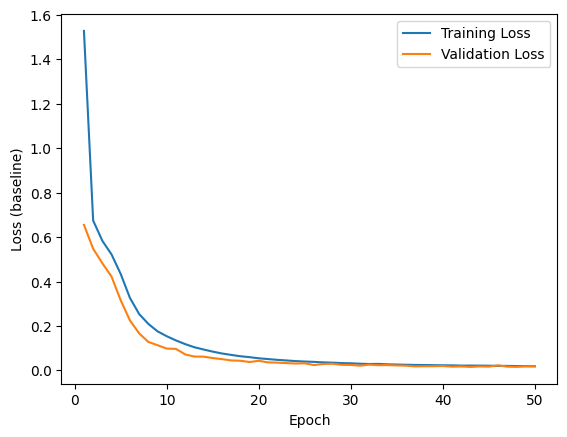

In [42]:
# plot baseline loss
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, train_loss_base, label='Training Loss')
plt.plot(epoch_list, val_loss_base, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (baseline)')
plt.legend()

# LightGCN with lyrics and audio features

In [43]:
model = LightGCN(n_layers, num_users, num_tracks, random_dim=random_dim, lyrics_dim=lyrics_dim, audio_dim=audio_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(model.parameters())])

Size of Learnable Embedding :  [torch.Size([34997, 128])]


In [44]:
train_loss, val_loss, mrr = train_and_eval(model, optimizer, train_data, val_data)

  0%|          | 0/50 [00:00<?, ?it/s]

mrr: 0.46197661868654877
mrr: 0.5022280999014946
mrr: 0.5251181480832559
mrr: 0.5400933253752538
mrr: 0.552634556965234
mrr: 0.5619960415298385
mrr: 0.5686517764804309
mrr: 0.5729754344801561
mrr: 0.577856286360469
mrr: 0.5802785080383356
mrr: 0.5815142429478878
mrr: 0.5851606594437788
mrr: 0.5831358847524297
mrr: 0.5883765499573842
mrr: 0.5887718555474418
mrr: 0.5910963964267332
mrr: 0.5926288553859927
mrr: 0.5926370341919656
mrr: 0.5933459278889056
mrr: 0.5939130716999981
mrr: 0.596345557592897
mrr: 0.5946204142911597
mrr: 0.5931216700662324
mrr: 0.5968531977798023
mrr: 0.5971922259970784
mrr: 0.5965681640169858
mrr: 0.5987796166921336
mrr: 0.5966480859710959
mrr: 0.5997843888445878
mrr: 0.5996249916354578
mrr: 0.6008176504841901
mrr: 0.600759361199805
mrr: 0.6007266488613203
mrr: 0.600671302974553
mrr: 0.6011944395522586
mrr: 0.6012397337987827
mrr: 0.6024840503073244
mrr: 0.6001519015525256
mrr: 0.6025171329610651
mrr: 0.6024994787340902
mrr: 0.6000892585030625
mrr: 0.6021790705861

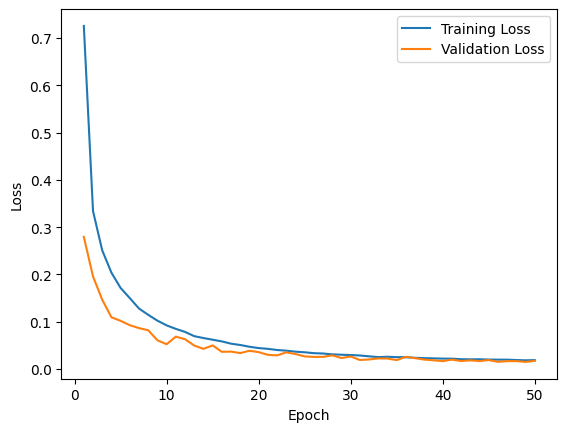

In [45]:
# plot our model's loss
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, train_loss, label='Training Loss')
plt.plot(epoch_list, val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Model comparisons

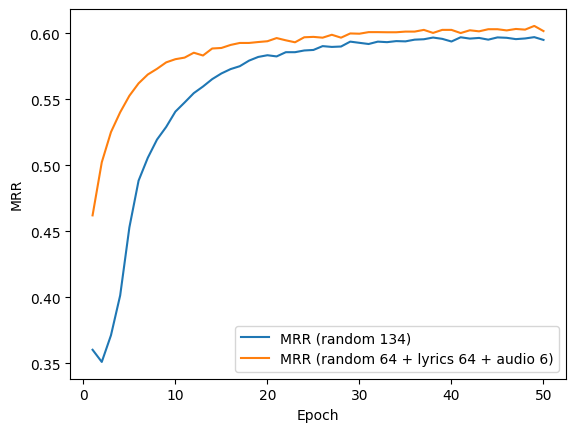

In [46]:
# compare mrr between baseline and our model
plt.plot(epoch_list, mrr_base, label='MRR (random 134)')
plt.plot(epoch_list, mrr, label='MRR (random 64 + lyrics 64 + audio 6)')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()

In [47]:
print('val_mrr_base:', mrr_base[-1])
print('val_mrr:', mrr[-1])

val_mrr_base: 0.5949
val_mrr: 0.6016


We save both model's results for more analysis.

In [48]:
import pandas as pd
import zipfile
import pickle

results_folder = '/content'

def eval_results(test, model):
    model.eval()
    test_candidates = {graph_track_id: test_cand_list for _, (graph_track_id, test_cand_list) in test[['graph_track_id', 'test_candidates']].iterrows()}
    with torch.no_grad():
        out = model(train_edge_index)
        final_item_emb, final_user_emb = torch.split(out, (num_tracks, num_users))
        mrr = get_mrr(final_user_emb, final_item_emb, num_tracks, test, all_data, test_candidates=test_candidates)
    return mrr

def get_results(test_res, valid_res_list, valid_loss_list, train_loss_list):
    df = pd.DataFrame({
        'test_result': [test_res],
        'valid_results': [valid_res_list],
        'valid_losses': [valid_loss_list],
        'train_losses': [train_loss_list]
    })
    return df

def zip_dataframe_and_model(df, model, folder_path, zip_filename):
    """
    Zips a Pandas DataFrame and a model into a specified folder.

    Args:
        df (pd.DataFrame): The DataFrame to zip.
        model: The model object to zip.
        folder_path (str): The path to the folder where the zip file will be created.
        zip_filename (str): The name of the zip file.
    """

    with zipfile.ZipFile(f"{folder_path}/{zip_filename}", 'w') as zipf:
        # Save DataFrame to CSV and add to zip
        df.to_csv("results.csv", index=False)
        zipf.write("results.csv")

        # Save model to pickle and add to zip
        with open("model.pkl", 'wb') as model_file:
            pickle.dump(model, model_file)
        zipf.write("model.pkl")

test_mrr_base = eval_results(test_data, lightGCN_baseline)
print('base:', test_mrr_base)
results_df = get_results(test_mrr_base, mrr_base, val_loss_base, train_loss_base)
zip_dataframe_and_model(results_df, lightGCN_baseline, folder_path = results_folder, zip_filename = f'lgcn_base_{n_layers}_{random_dim+lyrics_dim+audio_dim}')

test_mrr = eval_results(test_data, model)
print('model:', test_mrr)
results_df = get_results(test_mrr, mrr, val_loss, train_loss)
zip_dataframe_and_model(results_df, model, folder_path = results_folder, zip_filename = f'lgcn_{n_layers}_{random_dim}_{lyrics_dim}_{audio_dim}')

base: 0.5607578932902877
model: 0.5674406168568437
